# Stock Data Analysis for Pairs Trading

In this notebook, we will explore the concept of pairs trading in the stock market. Pairs trading is a strategy that involves trading two highly correlated stocks. The idea is to identify pairs of stocks whose prices move together. If the price movement diverges, a trader can buy one stock and short the other, expecting their prices to converge again.

We will start by fetching historical data for a selected list of stocks, analyze their price correlations, and identify potential pairs for trading.


In [29]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
import seaborn as sns
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')



## Fetching Historical Stock Data

The function `get_historical_Data` is designed to download historical stock data. We use the `yfinance` library to fetch the adjusted closing prices of the stocks over a specified period. Adjusted closing prices are used because they account for all dividends and stock splits, giving a more accurate picture of the stock's value over time.

Let's fetch the data for a predefined list of stock tickers.


In [16]:
def get_historical_Data(tickers):
    """This function returns a pd dataframe with all of the adjusted closing information"""
    data = pd.DataFrame()
    names = list()
    for i in tickers:
        # downloading data from yfinance
        data = pd.concat([data, pd.DataFrame(yf.download(i, start=datetime(2020, 10, 27), end=datetime(2021, 10, 27)).iloc[:,4])], axis = 1)
        names.append(i)
    data.columns = names
    return data

ticks = ["DPZ", "AAPL", "GOOG", "AMD", "GME", "SPY", "NFLX", "BA", "WMT","DASH","GS","XOM","NKE","AMZN", "META","BRK-B", "MSFT"]
d = get_historical_Data(ticks)
# Most Recent Data
d.tail()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,DPZ,AAPL,GOOG,AMD,GME,SPY,NFLX,BA,WMT,DASH,GS,XOM,NKE,AMZN,META,BRK-B,MSFT
Date,,,,,,,,,,,,,,,,,
2021-10-20,446.019135,147.358780,142.414993,116.389999,46.130001,436.987396,625.140015,216.169998,141.013229,215.679993,383.174866,58.598621,154.487534,170.753006,340.779999,287.489990,301.328217
2021-10-21,455.142212,147.576004,142.780502,119.330002,45.427502,438.127106,653.159973,214.339996,141.795578,218.820007,382.893005,57.534027,158.124283,171.750504,341.880005,286.820007,304.611969
2021-10-22,451.611664,146.796066,138.625000,119.820000,42.450001,437.673218,664.780029,212.970001,143.273300,213.830002,389.215240,57.928661,159.391769,166.777496,324.609985,289.239990,303.043671
2021-10-25,453.469330,146.746674,138.772995,122.360001,43.492500,440.020355,671.659973,212.869995,144.934570,216.330002,389.619202,59.057499,160.113266,166.018494,328.690002,290.260010,302.033997
2021-10-26,453.021973,147.418060,139.671997,122.930000,44.459999,440.416382,668.520020,209.809998,143.669312,212.929993,392.305878,60.424950,159.694016,168.803497,315.809998,290.850006,303.974792


## Correlation Analysis

To identify pairs of stocks that move together, we calculate the correlation between the stocks' prices. A correlation close to 1 indicates that the stocks tend to move in the same direction, which is what we are looking for in pairs trading.

Let's create a correlation matrix for our stocks and visualize it using a heatmap for easier interpretation.


In [17]:
corr_matrix = d.corr()
corr_matrix

,DPZ,AAPL,GOOG,AMD,GME,SPY,NFLX,BA,WMT,DASH,GS,XOM,NKE,AMZN,META,BRK-B,MSFT
DPZ,1.000000,0.818148,0.874797,0.665388,0.469130,0.834557,0.372663,0.080836,0.407599,0.498128,0.724772,0.497005,0.812071,0.677479,0.938272,0.715105,0.872942
AAPL,0.818148,1.000000,0.817185,0.788684,0.430274,0.832325,0.659198,0.095350,0.373090,0.724907,0.729216,0.498231,0.862453,0.720923,0.761094,0.608197,0.886737
GOOG,0.874797,0.817185,1.000000,0.572945,0.717871,0.978253,0.542024,0.332867,0.120377,0.462236,0.933673,0.794650,0.729426,0.649917,0.919678,0.901955,0.974893
AMD,0.665388,0.788684,0.572945,1.000000,0.076881,0.555607,0.697511,-0.128145,0.555588,0.790243,0.447324,0.182714,0.814614,0.356671,0.522507,0.288319,0.681377
GME,0.469130,0.430274,0.717871,0.076881,1.000000,0.737520,0.240664,0.562551,-0.303935,-0.049770,0.803210,0.823951,0.303382,0.387215,0.631324,0.800656,0.647865
SPY,0.834557,0.832325,0.978253,0.555607,0.737520,1.000000,0.532301,0.442483,0.118445,0.417450,0.964367,0.844584,0.731238,0.650912,0.887417,0.932636,0.955292
NFLX,0.372663,0.659198,0.542024,0.697511,0.240664,0.532301,1.000000,-0.031222,0.105739,0.688781,0.480084,0.369577,0.502257,0.333158,0.347908,0.301593,0.651469
BA,0.080836,0.095350,0.332867,-0.128145,0.562551,0.442483,-0.031222,1.000000,-0.313237,-0.594470,0.510482,0.671750,0.079400,0.114948,0.260697,0.568068,0.229572
WMT,0.407599,0.373090,0.120377,0.555588,-0.303935,0.118445,0.105739,-0.313237,1.000000,0.483614,-0.044591,-0.326003,0.399259,0.193177,0.280621,-0.007302,0.187106
DASH,0.498128,0.724907,0.462236,0.790243,-0.049770,0.417450,0.688781,-0.594470,0.483614,1.000000,0.306549,0.023329,0.608831,0.391790,0.345440,0.068348,0.577595


### Heatmap

Text(0.5, 1.0, 'Stock Correlation Matrix')

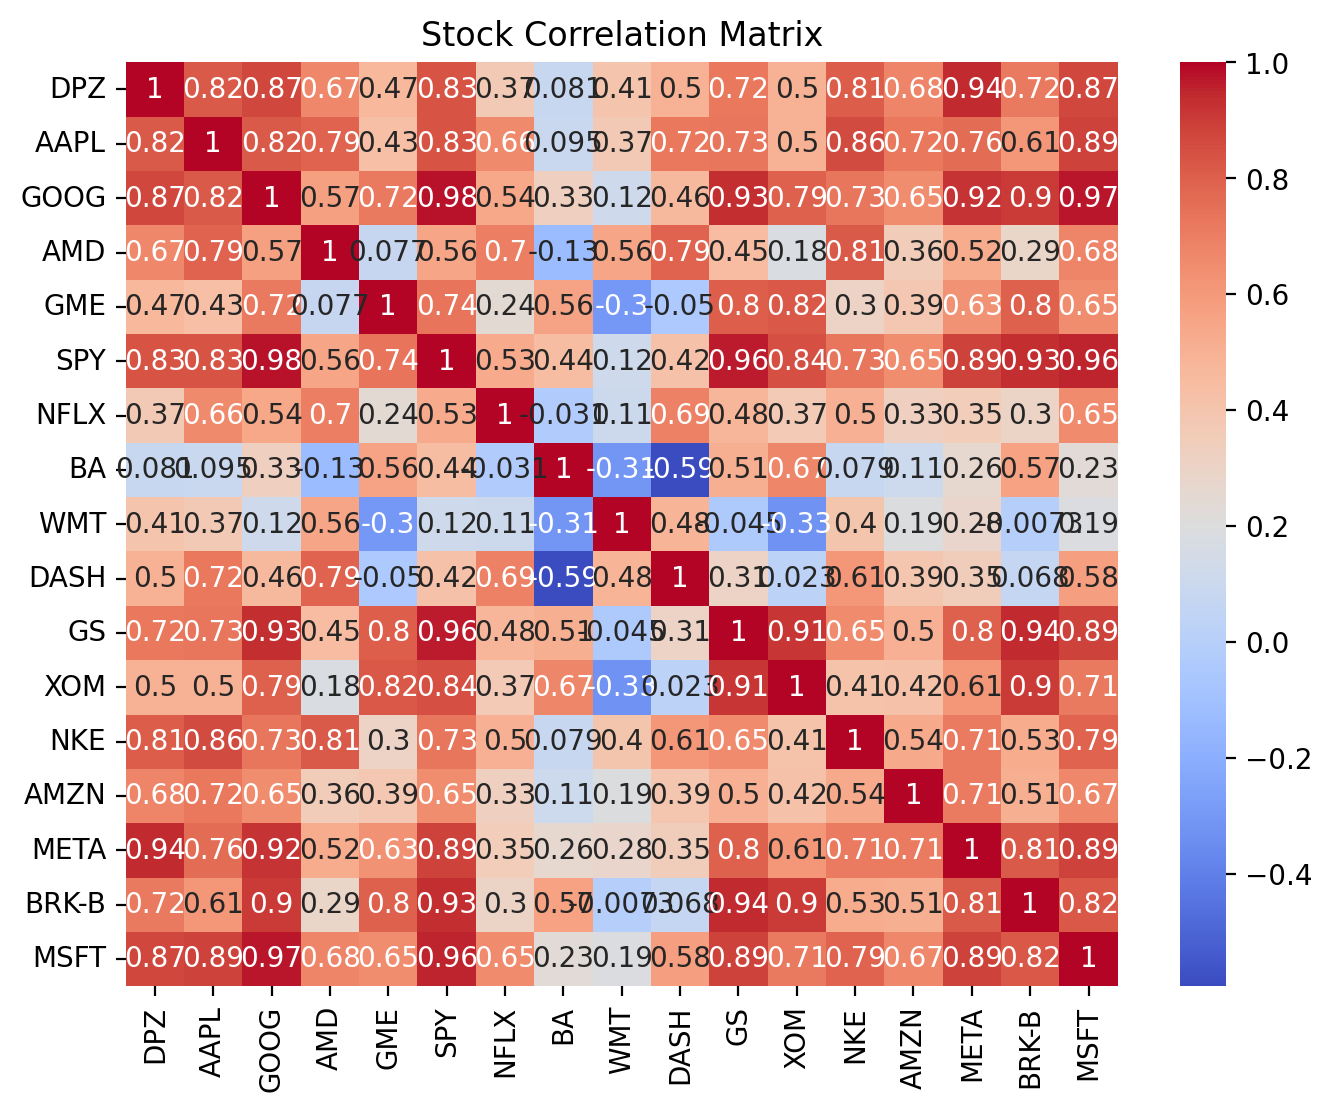

In [19]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=200)
sns.heatmap(corr_matrix, annot = True, cmap='coolwarm')
plt.title('Stock Correlation Matrix')

## Identifying Potential Pairs

With our correlation matrix, we can now identify pairs of stocks that have a high correlation. In pairs trading, we are particularly interested in stock pairs with a very high correlation (e.g., above 0.95). These pairs might present viable opportunities for pairs trading.

Let's identify and list all pairs with a correlation above our threshold.


In [23]:
threshold = 0.95
pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

print("Identified Pairs:", pairs)


Identified Pairs: [('SPY', 'GOOG'), ('GS', 'SPY'), ('MSFT', 'GOOG'), ('MSFT', 'SPY')]


## Pair Validation

After identifying pairs with high correlation, the next step is to validate these pairs to ensure they are suitable for pairs trading. This validation involves three key analyses:

1. **Cointegration Test**: To check if the pairs are cointegrated, suggesting a long-term equilibrium relationship.
2. **Mean Reversion Analysis**: To determine if the spread of the pair reverts to its mean over time.
3. **Hurst Exponent Calculation**: To assess the nature of the spread movement – whether it's random, trending, or mean-reverting.

Let's proceed with these analyses for our identified pairs.


### Cointegration Test

We use the Augmented Dickey-Fuller (ADF) test to check for cointegration. If the p-value of the test is below a certain threshold (commonly 0.05), we consider the pair to be cointegrated.


In [33]:
from statsmodels.tsa.stattools import adfuller

def check_cointegration(pair):
    # Calculate the spread
    spread = d[pair[0]] - d[pair[1]]
    # Perform Augmented Dickey-Fuller test
    adf_result = adfuller(spread)
    return adf_result[1]  # p-value

cointegrated_pairs = []
for pair in pairs:
    p_value = check_cointegration(pair)
    if p_value < 0.05:  # Threshold for cointegration
        cointegrated_pairs.append(pair)
        print(f'Pair {pair} is cointegrated with a p-value of {p_value:.4f}.')
    else:
        print(f'Pair {pair} is not cointegrated (p-value: {p_value:.4f}).')

print("\nCointegrated Pairs:", cointegrated_pairs)


Pair ('SPY', 'GOOG') is not cointegrated (p-value: 0.2956).
Pair ('GS', 'SPY') is not cointegrated (p-value: 0.3015).
Pair ('MSFT', 'GOOG') is not cointegrated (p-value: 0.8684).
Pair ('MSFT', 'SPY') is cointegrated with a p-value of 0.0163.

Cointegrated Pairs: [('MSFT', 'SPY')]


### Mean Reversion Analysis

Next, we analyze whether the spread between the stock prices in each pair shows mean-reverting behavior. We calculate the half-life of mean reversion, which indicates how quickly the spread reverts to its mean.

We will calculate the half-life of mean reversion for the spread between MSFT and SPY. It is a measure of how many days it takes for the spread between these two stocks to revert to half of its deviation from the mean.


In [32]:
from sklearn.linear_model import LinearRegression

def calculate_half_life(spread):
    # Calculate the spread lagged by one day
    spread_lag = spread.shift(1).dropna()
    spread_lag_const = sm.add_constant(spread_lag)
    spread_diff = spread.diff().dropna()

    # Convert column names to string if they are not, to avoid TypeError
    spread_lag_const.columns = spread_lag_const.columns.astype(str)

    # Perform linear regression
    lin_reg = LinearRegression()
    lin_reg.fit(spread_lag_const, spread_diff)

    # Calculate half life
    half_life = -np.log(2) / lin_reg.coef_[1]
    return half_life

mean_reversion_half_lives = {}
for pair in cointegrated_pairs:
    spread = d[pair[0]] - d[pair[1]]
    mean_reversion_half_lives[pair] = calculate_half_life(spread)

for pair, half_life in mean_reversion_half_lives.items():
    print(f"Half-life of mean reversion for the pair {pair[0]} and {pair[1]} is approximately {half_life:.2f} days.")


Half-life of mean reversion for the pair MSFT and SPY is approximately 14.48 days.


A half-life of 14.48 days means that if the spread between MSFT and SPY deviates from its historical average, it's expected to take approximately 14.48 days for the spread to close half of that deviation.

This metric is crucial in pairs trading strategies as it gives an indication of how quickly you might expect a return to the mean, which is where the trading profit lies in such strategies.

### Hurst Exponent Calculation

Finally, we calculate the Hurst Exponent for each pair. A Hurst exponent close to 0.5 suggests a random walk, values less than 0.5 indicate mean-reverting behavior, and values greater than 0.5 imply a trending market.


In [40]:
def calculate_hurst_exponent(ts):
    """Returns the Hurst Exponent of the time series"""
    # Check for constant time series
    if ts.std() == 0:
        return np.nan

    lags = range(2, 100)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Check for zero standard deviation
    if all(t == 0 for t in tau):
        return np.nan

    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]*2.0

hurst_exponents = {}
for pair in cointegrated_pairs:
    spread = d[pair[0]] - d[pair[1]]
    hurst = calculate_hurst_exponent(spread)
    if not np.isnan(hurst):
        hurst_exponents[pair] = hurst

print("Hurst Exponents:", hurst_exponents)


Hurst Exponents: {}


## Plotting the Spread

('MSFT', 'SPY') count    252.000000
mean    -142.071527
std        9.473988
min     -161.498962
25%     -147.669426
50%     -142.181305
75%     -136.317245
max     -114.277512
dtype: float64


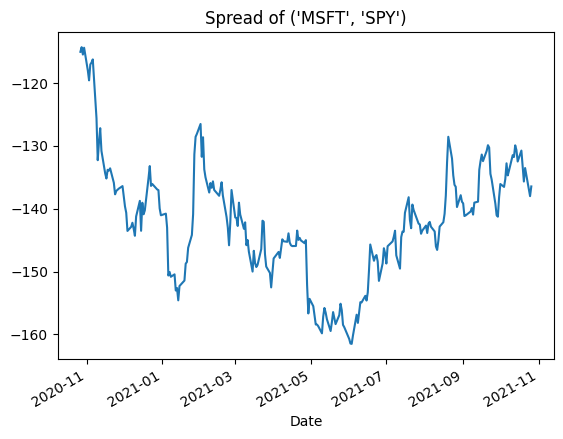

In [38]:
for pair in cointegrated_pairs:
    spread = d[pair[0]] - d[pair[1]]
    print(pair, spread.describe())
    spread.plot(title=f"Spread of {pair}")


## Z-Score Analysis of Stock Price Ratio

In this section, we visualize the Z-scores of the ratio of stock prices between MSFT and SPY. The Z-score is a statistical measure that describes a value's relationship to the mean of a group of values, measured in terms of standard deviations from the mean. 

### Why Use Z-Scores?

Z-scores are particularly useful in pairs trading as they help to standardize different price scales of stocks, allowing us to:

- **Identify Deviations**: Spot significant deviations of the ratio from its historical average.
- **Signal for Trading**: Detect potential trading opportunities when the ratio deviates beyond certain thresholds.

### How to Interpret the Plot

- The plot shows the Z-scores of the ratio of MSFT to SPY over time.
- The **horizontal lines** represent different levels of standard deviations:
  - **Red Lines**: Represent +/- 1.25 standard deviations.
  - **Green Lines**: Represent +/- 1.0 standard deviation.
- **Trading Signals**:
  - When the Z-score **crosses above the upper red/green line**, it indicates that the ratio is significantly higher than its historical mean. This can be a signal to **short the pair** (i.e., short MSFT and long SPY), expecting the ratio to revert to the mean.
  - Conversely, when the Z-score **falls below the lower red/green line**, it suggests the ratio is significantly lower than the mean, potentially a signal to **go long on the pair** (i.e., long MSFT and short SPY).


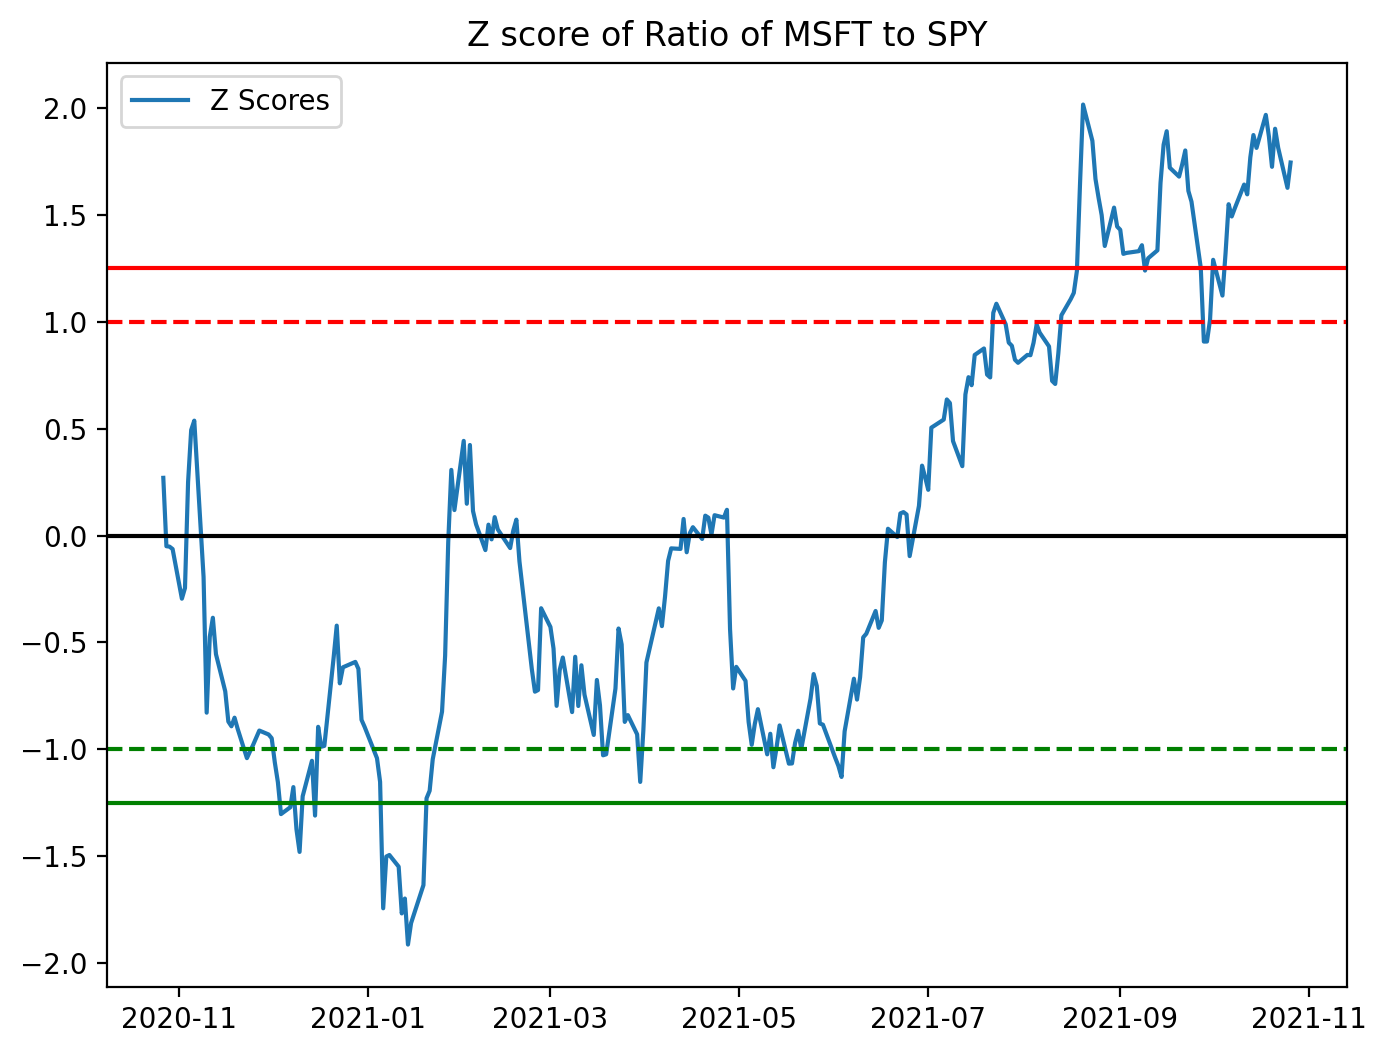

In [42]:
msft_prices = d[pair[0]]
spy_prices = d[pair[1]]

# Calculate the ratio
ratio = msft_prices / spy_prices

# Calculate Z-scores of the ratio
ratio_mean = ratio.mean()
ratio_std = ratio.std()
df_zscore = (ratio - ratio_mean) / ratio_std

# Plotting
plt.figure(figsize=(8, 6), dpi=200)
plt.plot(df_zscore, label="Z Scores")
plt.axhline(df_zscore.mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')  # 68% of our data will lie between these bounds
plt.axhline(1.25, color='red')  # 95% of our data will lie between these bounds
plt.axhline(-1.0, color='green', linestyle='--')  # 68% of our data will lie between these bounds
plt.axhline(-1.25, color='green')  # 95% of our data will lie between these bounds
plt.legend(loc='best')
plt.title('Z score of Ratio of MSFT to SPY')
plt.show()
